In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import tqdm 
from  scipy import ndimage
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Vgg16:
    def __init__(self, param_file, height, width):
        self.layers = {}        
        self.data_dict = np.load(param_file, encoding="latin1").item()
        
        self.input = tf.Variable(np.zeros((1, height, width, 3)), dtype=tf.float32)
        
        self.conv1_1 = self.conv_layer(self.input, 'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1, 'conv1_2')
        self.pool1 = self.max_pool_layer(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, 'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1, 'conv2_2')
        self.pool2 = self.max_pool_layer(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, 'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1, 'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2, 'conv3_3')
        self.pool3 = self.max_pool_layer(self.conv3_3, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, 'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1, 'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2, 'conv4_3')
        self.pool4 = self.max_pool_layer(self.conv4_3, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, 'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1, 'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2, 'conv5_3')
        self.pool5 = self.max_pool_layer(self.conv5_3, 'pool5')
        
        self.layers={}
        self.layers['input'] = self.input
        self.layers['conv1_1'] = self.conv1_1
        self.layers['conv1_2'] = self.conv1_2
        self.layers['pool1'] = self.pool1
        self.layers['conv2_1'] = self.conv2_1
        self.layers['conv2_2'] = self.conv2_2
        self.layers['pool2'] = self.pool2
        self.layers['conv3_1'] = self.conv3_1
        self.layers['conv3_2'] = self.conv3_2
        self.layers['conv3_3'] = self.conv3_3
        self.layers['pool3'] = self.pool3
        self.layers['conv4_1'] = self.conv4_1
        self.layers['conv4_2'] = self.conv4_2
        self.layers['conv4_3'] = self.conv4_3
        self.layers['pool4'] = self.pool4
        self.layers['conv5_1'] = self.conv5_1
        self.layers['conv5_2'] = self.conv5_2
        self.layers['conv5_3'] = self.conv5_3
        self.layers['pool5'] = self.pool5


    def conv_layer(self, input, name):
        filter = self.get_weight(name)
        bias = self.get_bias(name)
        conv = tf.nn.conv2d(input, filter, strides=[1,1,1,1], padding='SAME', name=name)
        layer = tf.nn.relu(tf.nn.bias_add(conv, bias))
        print('{} : {}'.format(name, layer.get_shape()))
        return layer

    def max_pool_layer(self, input, name):
        layer = tf.nn.max_pool(input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
        print('max_{} : {}'.format(name, layer.get_shape()))
        return layer

    def avg_pool_layer(self, input, name):
        layer =  tf.nn.avg_pool(input, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
        print('avg_{} : {}'.format(name, layer.get_shape()))
        return layer

    def fc_layer(self, input, name):
        weight = self.get_weight(name)
        bias = self.get_bias(name)
        layer =  tf.add(tf.matmul(input, weight), bias)
        print('{} : {}'.format(name, layer.get_shape()))
        return layer

    def get_weight(self,name):
        return tf.constant(self.data_dict[name][0])

    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1])

In [3]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, content_image.shape).astype('float32')    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,3)) 
    image = image - MEANS 
    image = np.expand_dims(image, axis=0)
    return image[:,:,:,::-1]


def restore_image(image):
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    # Un-normalize the image so that it looks good
    image = image[:,:,:,::-1]
    image = image + MEANS
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    return image

def load_image(path):
    # return ndimage.imread(path)
    return skimage.io.imread(path)

def resize_image(image, shape=[224,224]):
    image = skimage.transform.resize(image, shape, mode="reflect")
    image = (image*255).astype('uint8')
    return image

In [4]:
def compute_layer_content_cost(a_C, a_G):
    """ 
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the contentimage C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the generated image G 
    """
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    J_content = tf.reduce_sum(tf.squared_difference(a_C,a_G)) / (4 * n_H * n_W * n_C) 
    return J_content

In [5]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the style image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the generated image G
     """
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, [-1, n_C])
    a_G = tf.reshape(a_G, [-1, n_C])
    
    Gram_S = tf.matmul(tf.transpose(a_S), a_S)
    Gram_G = tf.matmul(tf.transpose(a_G), a_G)
    J_style = tf.reduce_sum(tf.squared_difference(Gram_S,Gram_G)) / (2 * n_H * n_W * n_C)**2
    return J_style

In [6]:
CONTENT_LAYER = 'conv3_3' 
def compute_content_cost(sess, content_image, model, CONTENT_LAYER):
    sess.run(model.layers['input'].assign(content_image))
    out = model.layers[CONTENT_LAYER]
    a_C = sess.run(out)
    a_G = out
    J_content = compute_layer_content_cost(a_C, a_G)
    return J_content

In [7]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]
def compute_style_cost(sess, style_image, model, STYLE_LAYERS):
    J_style = 0 
    sess.run(model.layers['input'].assign(style_image))
    for layer_name, coeff in STYLE_LAYERS:
        out = model.layers[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style += coeff * compute_layer_style_cost(a_S, a_G)
    return J_style

In [8]:
def total_cost(J_content, J_style, alpha = 1, beta = 100):
    J = alpha*J_content + beta*J_style
    return J

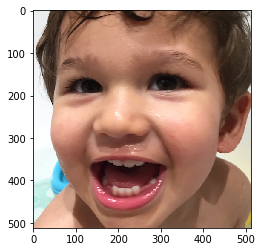

In [9]:
content_image = load_image("images/hugo.jpg")
plt.imshow(content_image)
content_image = reshape_and_normalize_image(content_image)

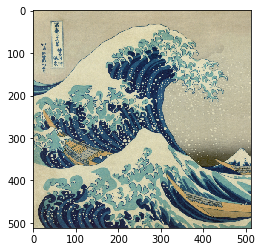

In [10]:
style_image = load_image("images/styles/wave.jpg")
style_image = resize_image(style_image, [512, 512])
style_image = reshape_and_normalize_image(style_image)
plt.imshow(restore_image(style_image))

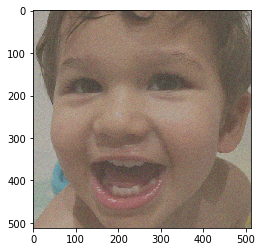

In [11]:
generated_image = generate_noise_image(content_image)
plt.imshow(restore_image(generated_image))

conv1_1 : (1, 512, 512, 64)
conv1_2 : (1, 512, 512, 64)
max_pool1 : (1, 256, 256, 64)
conv2_1 : (1, 256, 256, 128)
conv2_2 : (1, 256, 256, 128)
max_pool2 : (1, 128, 128, 128)
conv3_1 : (1, 128, 128, 256)
conv3_2 : (1, 128, 128, 256)
conv3_3 : (1, 128, 128, 256)
max_pool3 : (1, 64, 64, 256)
conv4_1 : (1, 64, 64, 512)
conv4_2 : (1, 64, 64, 512)
conv4_3 : (1, 64, 64, 512)
max_pool4 : (1, 32, 32, 512)
conv5_1 : (1, 32, 32, 512)
conv5_2 : (1, 32, 32, 512)
conv5_3 : (1, 32, 32, 512)
max_pool5 : (1, 16, 16, 512)


100%|█| 200/200 [1:14:53<00:00, 19.75s/it, total cost=4.68e+08, content cost=5.79e+04, style cost=4.68e+06]


result--------


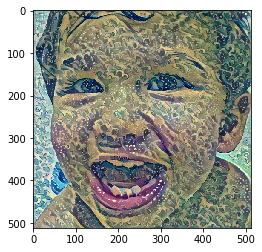

In [12]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = Vgg16('vgg16.npy', 512, 512)

J_content = compute_content_cost(sess, content_image, model, CONTENT_LAYER)
J_style = compute_style_cost(sess, style_image, model, STYLE_LAYERS)
J = total_cost(J_content, J_style)

opt = tf.train.AdamOptimizer(2.0).minimize(J)

sess.run(tf.global_variables_initializer())
sess.run(model.input.assign(generated_image))

num_iterations = 200
costs=[]
# desc = "total cost ={}; content cost = {}; style cost = {} ".format(Jt, Jc, Js)
t = tqdm.trange(num_iterations)
for i in t:
    sess.run(opt)
    G = sess.run(model.input)
    Jt, Jc, Js = sess.run([J, J_content, J_style])
    t.set_postfix({'total cost':Jt ,'content cost':Jc, 'style cost':Js})
    costs.append([Jt, Jc, Js])
    if i%20 == 0:
        #plt.imshow(restore_image(G))
        skimage.io.imsave("output/hugo_wave" + str(i) + ".png", restore_image(G))
skimage.io.imsave("hugo_wave_generated_image.jpg", restore_image(G))
print("result--------")
plt.imshow(restore_image(G))

(3, 200)


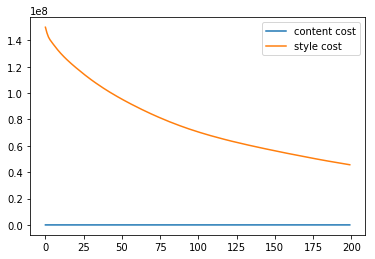

In [13]:
costs = np.array(costs).T
print(costs.shape)
plt.plot(costs[1], label="content cost")
plt.plot(costs[2], label="style cost")
plt.legend()